# Optimizing Solar Irradiance Prediction: Feature Selection for All-Sky Image Processing Using a Hybrid Prediction Method (ID 9222)

This source code was used in paper "**MACIEL J.M, SOUZA G.C, ZALEWSKI W., LEDESMA J.J.G., ANDO JUNIOR O. H. Optimizing Solar Irradiance Prediction: Feature Selection for All-Sky Image Processing Using a Hybrid Prediction Method (ID 9222). IEEE Latin America Transactions, 2024. DOI: (to be published).** 

This code is being made available to encourage scientific reproducibility.

Here, an Artificial Neural Network (ANN) is developed to to predict the Global Horizontal Irradiance (GHI) with different sets of input features extracted from all-sky images, whose method and dataset are provided in paper https://doi.org/10.1016/j.rser.2023.114185.

The objective is the prediction accuracy GHI evaluation from different input feature sets (Complete, Medium and Reduced) extracted from all-sky image with Image Processing techniques. These features are used as input of Artificial Neural Networks (ANN). The accuracy results will be compared among themselves and with those presented in https://doi.org/10.1016/j.rser.2023.114185.

The complete features dataset, used in this source-code, is available in https://doi.org/10.3390/data9100113.

Authors: Joylan Nunes Maciel, Gustavo Campoi de Souza, Willian Zalewski, Jorge Javier Gimenez Ledesma and Oswaldo Hideo Ando Junior

Date: Octubre 07, 2024

# Applied Method: Features Selection by Correlation
Person Correlation versus folsomGHI was computed from dataset https://doi.org/10.3390/data9100113.
### Complete Set (9 inputs)
* fitLuminanceCSI	: pearson 0.97
* clearSkyGhi	: pearson 0.91
* SunLuminance	: pearson	0.84
* loudsSunAround	: pearson 	-0.79
* cloudsCoverage	: pearson	0.76
* cloudsMovement	: pearson	-0.70
* sunLocated	: pearson 	0.56
* whitePixelRatio	: pearson 	0.24
* season	: pearson	0.11

### Medium Set (6 inputs)
* fitLuminanceCSI
* clearSkyGhi
* SunLuminance
* cloudsSunAround
* cloudsCoverage
* cloudsMovement

### Reduced set (3 inputs)
* fitLuminanceCSI
* cloudsSunAround
* cloudsMovement

# Initial setup and imports


## MHP Predictions Using Artificial Neural Networks (ANNs)

ANN model for predicting Global Horizontal Irradiance (GHI) from features (metrics) extracted from all-sky images.

The features (metrics) were computed from all-sky images in the Folsom dataset available in [[Pedro et al, 2019]](https://zenodo.org/record/2826939).

## Importing generic packages and TensorFlow


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import zipfile
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import os
import pprint
import time
from matplotlib.dates import DateFormatter
from pandas import Timestamp

In [ ]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, InputLayer, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model,load_model, save_model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
print(f'[INFO] TF version: {tf.__version__}')

[INFO] TF version: 2.15.0


## Hyperparameter optimization settings, GPU/TPU usage, training, and predictions


In [ ]:
HYPER_TUNING = False #@param ["False", "True"] {type:"raw"}
USE_TPU = False #@param ["False", "True"] {type:"raw"}
USE_GPU = False #@param ["False", "True"] {type:"raw"}
TRAINING_MODELS = True #@param ["False", "True"] {type:"raw"}
MAKE_PREDICTIONS = True #@param ["False", "True"] {type:"raw"}

In [ ]:
if HYPER_TUNING:
  !pip install --quiet optuna
  import optuna
  from optuna.trial import TrialState
  print(f'[INFO] Optuna version: {optuna.__version__}')

## Configuration of GPU, TPU, and RAM usage


## Definition of accuracy metrics


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

EPSILON = 1e-10

def _naive_forecasting(actual: np.ndarray):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-1]

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def _percentage_err(actual: np.ndarray, predicted: np.ndarray):
    """ Note: result is NOT multiplied by 100 """
    return _error(actual, predicted) / (actual + EPSILON)

def mae_err(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return mean_absolute_error(actual, predicted)

def mse_err(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    # return np.mean(np.square(_error(actual, predicted)))
    return mean_squared_error(actual, predicted)

def rmse_err(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mean_squared_error(actual, predicted))

def nrmse_err(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse_err(actual, predicted) / (actual.max() - actual.min())

def mase_err(actual: np.ndarray, predicted: np.ndarray):
  """ Mean Absolute Scaled Error Baseline is computed with naive forecasting """
  return float(mean_absolute_error(actual, predicted) /
               mean_absolute_error(actual[1:], _naive_forecasting(actual)))

def fss_err(actual: np.ndarray, predicted: np.ndarray):
    """ Associated Forecast Skill Score (SS) with RMSE """
    return 100 * (1.0 - (rmse_err(actual, predicted) /
                    rmse_err(actual[1:], _naive_forecasting(actual))))

def mape_err(actual: np.ndarray, predicted: np.ndarray):
  actual = 0.1 + 0.8 * ((actual - actual.min()) / (actual.max() - actual.min()))
  predicted = 0.1 + 0.8 * ((predicted - predicted.min()) / (predicted.max() - predicted.min()))
  return 100.0 * mean_absolute_percentage_error(actual, predicted)

# Loading the dataset


In [ ]:
#@title Select the dataset (complete or daytime): { display-mode: "form" }
dataset_file = 'image_metrics.csv' #@param ['image_metrics.csv', 'complete_image_metrics.csv']

In [ ]:
if USE_TPU:
    if 'COLAB_TPU_ADDR' not in os.environ:
        print('[INFO] ERROR: Not connected to a TPU runtime')
    else:
        tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        print ('[INFO] TPU address is', tpu_address)

    with tf.compat.v1.Session(tpu_address) as session:
        devices = session.list_devices()

    print('[INFO] TPU devices:')
    pprint.pprint(devices)

elif USE_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('[INFO] Not connected to a GPU')
    else:
      print(gpu_info)

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('\n[INFO] Found GPU at: {}'.format(device_name))


# High RAM use log
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('[INFO] Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))
if ram_gb < 20:
  print('[INFO] Not using a high-RAM runtime')
else:
  print('[INFO] You are using a high-RAM runtime!')


[INFO] Your runtime has 13.6 gigabytes of available RAM
[INFO] Not using a high-RAM runtime


In [ ]:
if 'google.colab' in str(get_ipython()):
  print('[INFO] Running on CoLab')
  import os
  import zipfile
  %matplotlib inline
  from google.colab import drive
  drive.mount('/content/drive')
  zip_ref = zipfile.ZipFile(f"/content/drive/MyDrive/predicao/dataset/{dataset_file}.zip", 'r')
  zip_ref.extractall("/tmp")
  zip_ref.close()
  df = pd.read_csv(f'/tmp/{dataset_file}',  sep=';', decimal=',')
  try:
    output = '/content/drive/MyDrive/predicaoann/resultados/'
    os.makedirs(output)
  except:
    print(f'[INFO] Output directory was created: {output}')
else:
  print('[INFO] Running on Local Machine')
  output = '/content/drive/MyDrive/predicaoann/'
  df = pd.read_csv(f'dataset/{dataset_file}', sep=';', decimal=',')
  df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f'[INFO] Dataset \"{dataset_file}\" com', df.shape[0], 'registros (linhas) e', df.shape[1],'features (colunas)')

[INFO] Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Output directory was created: /content/drive/MyDrive/predicaoann/resultados/
[INFO] Dataset "image_metrics.csv" com 764867 registros (linhas) e 19 features (colunas)


In [ ]:
df.head(10)

,timeStamp,season,cloudsCoverage,clearSkyGhi,sunLuminance,fitLuminanceCSI,sunLocated,cloudsSunAround,whitePixelRatio,cloudsMovement1,cloudsMovement2,cloudsMovement3,cloudsMovement4,cloudsMovement5,cloudsMovement10,cloudsMovement15,cloudsMovement30,cloudsMovement60,folsomGhi
0,2014-01-02 15:28:00,winter,0.0000,0.2352,22815.4352,5.6471,1.0,0.0090,0.0226,8.3540,11.1164,24.9497,141.5739,82.1980,218.4544,445.2738,766.0473,975.2004,4.87
1,2014-01-02 15:29:00,winter,0.0000,0.3683,23237.8289,9.0078,1.0,0.0100,0.0247,12.4268,25.6899,157.6565,84.6772,73.7872,247.3060,368.7858,962.2777,986.4231,5.59
2,2014-01-02 15:30:00,winter,0.0000,0.5418,21981.7314,12.5348,1.0,0.0152,0.0224,12.3462,104.6161,54.5732,64.1775,88.1236,245.7533,268.6592,825.9161,856.4872,1.23
3,2014-01-02 15:31:00,winter,0.0010,0.7616,21892.5041,17.5478,1.0,0.0166,0.0222,77.8820,29.8542,42.8217,65.0260,66.1551,263.6354,423.3711,707.4748,783.5681,1.62
4,2014-01-02 15:32:00,winter,0.0023,1.0333,17002.4532,18.4898,1.0,0.0447,0.0159,42.3108,130.2846,171.0328,132.9539,143.2481,278.1017,328.2594,544.6383,870.9897,2.04
5,2014-01-02 15:33:00,winter,0.0034,1.3621,21915.2377,31.4163,1.0,0.0167,0.0223,34.6271,55.9990,40.5497,49.3437,66.2691,224.4142,230.3980,500.6080,967.3377,2.52
6,2014-01-02 15:34:00,winter,0.0000,1.7528,25560.4518,47.1491,1.0,0.0099,0.0306,11.1120,15.0651,22.5627,77.5252,97.7835,181.9932,275.5374,526.5620,1092.8836,3.17
7,2014-01-02 15:35:00,winter,0.0000,2.2092,27126.5656,63.0681,1.0,0.0078,0.0352,13.8647,18.8305,80.3132,83.1253,107.3938,104.9208,223.7745,481.3895,1094.8400,3.90
8,2014-01-02 15:36:00,winter,0.0005,2.7348,26515.7135,76.3151,1.0,0.0129,0.0309,8.2126,44.9506,64.3337,78.9842,150.3269,292.1617,147.9582,354.0221,980.1458,4.64
9,2014-01-02 15:37:00,winter,0.0000,3.3322,27243.4410,95.5393,1.0,0.0108,0.0330,35.7801,50.2086,63.6134,132.2627,114.9473,232.3797,185.2433,317.4875,864.8244,5.36


In [ ]:
df.tail(10)

,timeStamp,season,cloudsCoverage,clearSkyGhi,sunLuminance,fitLuminanceCSI,sunLocated,cloudsSunAround,whitePixelRatio,cloudsMovement1,cloudsMovement2,cloudsMovement3,cloudsMovement4,cloudsMovement5,cloudsMovement10,cloudsMovement15,cloudsMovement30,cloudsMovement60,folsomGhi
764857,2016-12-31 00:38:00,winter,0.3163,3.8184,47545.8812,191.0664,1.0,1.0,0.0538,33.3758,10.7262,27.8362,95.0922,48.1016,65.7992,151.8934,289.2322,407.2952,12.99
764858,2016-12-31 00:39:00,winter,0.3096,3.1675,49724.1164,165.7544,1.0,1.0,0.0657,14.5238,9.5119,22.4350,14.4011,23.9588,65.7992,151.8934,289.2322,407.2952,11.27
764859,2016-12-31 00:40:00,winter,0.3040,2.5897,48065.2094,130.9969,1.0,1.0,0.0554,7.4098,50.9422,18.3984,28.1596,56.8767,65.7992,151.8934,289.2322,407.2952,9.84
764860,2016-12-31 00:41:00,winter,0.3083,2.0829,47534.3167,104.1982,1.0,1.0,0.0551,27.2819,6.2269,11.9297,30.4286,20.9672,65.7992,151.8934,289.2322,407.2952,8.52
764861,2016-12-31 00:42:00,winter,0.2925,1.6443,48717.6995,84.3058,1.0,1.0,0.0628,16.7116,16.6703,11.2357,39.1072,50.4091,65.7992,151.8934,289.2322,407.2952,7.38
764862,2016-12-31 00:43:00,winter,0.2924,1.2704,45942.2110,61.4246,1.0,1.0,0.0482,4.5227,14.4815,12.5460,18.4390,50.4091,65.7992,151.8934,289.2322,407.2952,6.14
764863,2016-12-31 00:44:00,winter,0.2907,0.9570,44465.3099,44.7840,1.0,1.0,0.0440,9.2924,8.4858,14.0048,18.4390,50.4091,65.7992,151.8934,289.2322,407.2952,5.13
764864,2016-12-31 00:45:00,winter,0.2791,0.6993,42859.5503,31.5432,1.0,1.0,0.0440,19.3580,26.2753,14.0048,18.4390,50.4091,65.7992,151.8934,289.2322,407.2952,4.22
764865,2016-12-31 00:46:00,winter,0.2862,0.4920,34795.3780,18.0175,1.0,1.0,0.0333,4.3986,26.2753,14.0048,18.4390,50.4091,65.7992,151.8934,289.2322,407.2952,3.37
764866,2016-12-31 00:47:00,winter,0.2840,0.3294,34122.7782,11.8306,1.0,1.0,0.0306,4.3986,26.2753,14.0048,18.4390,50.4091,65.7992,151.8934,289.2322,407.2952,2.76


# Feature Engineering

## Horário UTC-7 (Folsom/US), season, ano, mes, dia, hora e minuto

In [ ]:
# Converting timeStamp to datetime index
df.index = pd.to_datetime(df.timeStamp)
df = df.drop('timeStamp', axis=1)

# Converting UTC timezone to local US/Folsom timezone
df.index = (df.index - pd.Timedelta(hours=7))
df.head()

# Converts the 'season' column to a numeric class (1=winter, 2=spring, 3=summer, 4=autumn)
df['season'] = df['season'].map(
    {'winter': 1.0,
    'spring': 2.0,
    'summer': 3.0,
    'autumn': 4.0})

# Adds columns related to date and time
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute


In [ ]:
def process_dataset(dataset, horizon):
  # Processing the CMV column based on the selected prediction horizon
  cmv_column_name = 'cloudsMovement'+str(horizon)
  # Reordering the dataset columns
  dataset = dataset[['year', 'month', 'hour', 'day', 'minute',
          'season',
          cmv_column_name,
          'cloudsCoverage',
          'cloudsSunAround',
          'clearSkyGhi',
          'fitLuminanceCSI',
          'sunLuminance',
          'sunLocated',
          'whitePixelRatio',
          'folsomGhi']]
  # Renaming the selected cloudsMovement column based on the horizon
  dataset = dataset.rename(columns={cmv_column_name: 'cloudsMovement'})
  # Shifts the target variable to the next 'horizon' row
  lagged_ghi = pd.DataFrame(dataset['folsomGhi'].shift(-horizon))
  # Removes the target column to be predicted
  dataset = dataset.drop(['folsomGhi'], axis=1)
  # Concatenates the predicted column at the next prediction horizon
  dataset = pd.concat([dataset, lagged_ghi], axis=1)
  # Removes the last (horizon) records without target
  dataset = dataset[:-horizon]
  # dfp.fillna(value, inplace=True)
  return dataset


## Displaying all features of the dataset


In [ ]:
# @title Select the prediction horizon { display-mode: "form" }
horizon = "15" #@param [1, 5, 15]

# Dataset preparation and splitting


## Selection of input set (Complete; Medium; Reduced)


In [ ]:
setNames = []
# Function that returns two variables: a list with the three input sets (Xtemp) and the expected outputs (y)
def split_3inputs_output_columns(dataset):
    Xtemp = [] # We create a list where each element is a set

    setNames.append("CompleteInputSet")
    setNames.append("MediumInputSet")
    setNames.append("ReducedInputSet")

    # Input features in **X**
    Xa = dataset[['year', 'month', 'day', 'hour', 'minute',  'season', 'cloudsMovement', 'cloudsCoverage', 'cloudsSunAround', 'clearSkyGhi', 'fitLuminanceCSI', 'sunLuminance', 'sunLocated', 'whitePixelRatio']].copy()
    Xb = dataset[['year', 'month', 'day', 'hour', 'minute', 'cloudsMovement', 'cloudsCoverage', 'clearSkyGhi', 'fitLuminanceCSI', 'sunLuminance', 'cloudsSunAround']].copy()
    Xc = dataset[['year', 'month', 'day', 'hour', 'minute', 'cloudsMovement', 'cloudsSunAround', 'fitLuminanceCSI']].copy()

    Xtemp.append(Xa)
    Xtemp.append(Xb)
    Xtemp.append(Xc)

    # Output feature GHI in **y**
    y = dataset['folsomGhi']

    return (Xtemp), (y)

## Splitting the 3-folds for training/validation and testing


In [ ]:
range_folds = ['Fold-1: Train 2015, 2016 and test 2014',
               'Fold-2: Train 2014, 2016 and test 2015',
               'Fold-3: Train 2014, 2015 and test 2016']

# Index folds to train/test: [0, 1, 2]
start_fold = 0
end_fold = 2
num_folds= end_fold - start_fold + 1

def split_train_test_by_folds(X, y, input):
  X_train = []
  y_train = []
  X_test = []
  y_test = []

  start_month = '-01-01' # '-month-day'
  end_month= '-12-31'

  # Fold-1: Train 2015, 2016, Validation 11,12/2016 and test 2014
  X_train.append(X[f'2015{start_month}':f'2016{end_month}'])
  X_test.append(X[f'2014{start_month}':f'2014{end_month}'])
  y_train.append(y[f'2015{start_month}':f'2016{end_month}'])
  y_test.append(y[f'2014{start_month}':f'2014{end_month}'])

  # Fold-2: Train 2014, 2016, Validation 11,12/2014 and test 2015
  temp = pd.concat( [X[f'2014{start_month}':f'2014{end_month}'],  X[f'2016{start_month}':f'2016{end_month}']])
  X_train.append(temp)
  X_test.append(X[f'2015{start_month}':f'2015{end_month}'])
  temp = pd.concat( [y[f'2014{start_month}':f'2014{end_month}'],  y[f'2016{start_month}':f'2016{end_month}']])
  y_train.append(temp)
  y_test.append(y[f'2015{start_month}':f'2015{end_month}'])

  # Fold-3: Train 2014, 2015, Validation 11,12/2015 and test 2016
  X_train.append(X[f'2014{start_month}':f'2015{end_month}'])
  X_test.append(X[f'2016{start_month}':f'2016{end_month}'])
  y_train.append(y[f'2014{start_month}':f'2015{end_month}'])
  y_test.append(y[f'2016{start_month}':f'2016{end_month}'])
  print('\nDataset ', setNames[input])
  for i in range(start_fold, num_folds):
    print('\t'+range_folds[i])
    print('\t\tTrain samples: ', X_train[i].shape[0])
    print('\t\tTest samples:', X_test[i].shape[0])

  return X_train, y_train, X_test, y_test

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def scaler_X_dataset(X_train, X_test):
    scalerX = MinMaxScaler()
    for i in range(len(X_train)):
        X_train[i] = scalerX.fit_transform(X_train[i])
        X_test[i] = scalerX.transform(X_test[i])
    return X_train, X_test

def scaler_Y_dataset(y_train, y_test):
    scalerY = MinMaxScaler()
    for i in range(len(y_train)):
        y_train[i] = scalerY.fit_transform(y_train[i].values.reshape(-1, 1)).flatten()
        y_test[i] = scalerY.transform(y_test[i].values.reshape(-1, 1)).flatten()
    return y_train, y_test

## Hyperparameter optimization

In [ ]:
def runNN(trial):
    batch_size = 128
    n_layers = trial.suggest_int("n_layers", 2, 4)
    optimizer = 'adam'
    activation = 'relu'
    early_stopping_f = tf.keras.callbacks.EarlyStopping(
            patience=7,
            min_delta=0.001,
            restore_best_weights=True,
    )
    path_to_save_model = output + "mlp_optuna_model.h5"
    early_stop = EarlyStopping(monitor='val_loss',
                             mode='min',
                             verbose=1,
                             patience=10)

    save = ModelCheckpoint(filepath=path_to_save_model,
                        monitor="val_loss",
                        save_best_only=True)

    model = Sequential()
    model.add(Dense(X_train[0].shape[1], activation=activation, input_dim = X.shape[1]))
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_layer_{}".format(i), 50, 350, step=100)
        model.add(Dense(num_hidden, activation=activation))
    model.add(Dense(1))

    model.compile(optimizer = optimizer, loss='mae', steps_per_execution = 50, metrics=['mse','mae'])

    model.fit(X_train[1], y_train[1],
              batch_size=batch_size,
              epochs=100,
              validation_split=0.33,
              callbacks=[early_stopping_f, save],
              verbose=0)

    valid_pred = model.predict(X_test[1])
    valid_score = mae_err(y_test[1], valid_pred.squeeze())
    return valid_score

def make_parameters_hypertunning():
    try: # detect TPUs
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
        print('set strategy on tpu ', tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except ValueError: # detect GPUs
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('No tpu strategy set!')
        print("Number of accelerators: ", strategy.num_replicas_in_sync)

    with strategy.scope():
        study = optuna.create_study(direction="minimize")
        study.optimize(runNN, n_trials=60)
        print(study.best_params)
        trial = study.best_trial
        print('Accuracy: {}'.format(trial.value))
        print("Best hyperparameters: {}".format(trial.params))

    return study

In [ ]:
# # Plotting the optimization history of the study.
if HYPER_TUNING:
  import joblib
  study = make_parameters_hypertunning()
  optuna.visualization.plot_optimization_history(study)
  # Plotting the accuracies for each hyperparameter for each trial.
  optuna.visualization.plot_slice(study)
  # Plotting the accuracy surface for the hyperparameters involved in the random forest model.
  optuna.visualization.plot_contour(study, params=['n_layers', 'n_units_l0', 'n_units_l1', 'n_units_l2'])
  joblib.dump(study, f"{output}all_inputs_mlp_optuna_study.pkl")
else:
  print('Hipeturning with TPU disabled')

Hipeturning with TPU disabled


## Creation of the three (3) datasets with different inputs (features)


In [ ]:
horizon = int(horizon)
cmvColumnName = f'cloudsMovement'+str(horizon)
dftemp = df.copy()
dftemp = process_dataset(dftemp, horizon)

X_list, y = split_3inputs_output_columns(dftemp)
Xa_train, y_train, Xa_test, ya_test = split_train_test_by_folds(X_list[0], y, 0)
Xb_train, y_train, Xb_test, yb_test = split_train_test_by_folds(X_list[1], y, 1)
Xc_train, y_train, Xc_test, yc_test = split_train_test_by_folds(X_list[2], y, 2)

for i in [0,1,2]:
  print('\nDataset',setNames[i],f'with {len(X_list[i].columns.values)} input metrics: ',X_list[i].columns.values)

Xa_train, Xa_test = scaler_X_dataset(Xa_train, Xa_test)
Xb_train, Xb_test = scaler_X_dataset(Xb_train, Xb_test)
Xc_train, Xc_test = scaler_X_dataset(Xc_train, Xc_test)

X_train_list = []
X_test_list = []
y_test_list = []

X_train_list.append(Xa_train)
X_train_list.append(Xb_train)
X_train_list.append(Xc_train)
X_test_list.append(Xa_test)
X_test_list.append(Xb_test)
X_test_list.append(Xc_test)
y_test_list.append(ya_test)
y_test_list.append(yb_test)
y_test_list.append(yc_test)


Dataset  CompleteInputSet
	Fold-1: Train 2015, 2016 and test 2014
		Train samples:  522206
		Test samples: 242646
	Fold-2: Train 2014, 2016 and test 2015
		Train samples:  503180
		Test samples: 261672
	Fold-3: Train 2014, 2015 and test 2016
		Train samples:  504318
		Test samples: 260534

Dataset  MediumInputSet
	Fold-1: Train 2015, 2016 and test 2014
		Train samples:  522206
		Test samples: 242646
	Fold-2: Train 2014, 2016 and test 2015
		Train samples:  503180
		Test samples: 261672
	Fold-3: Train 2014, 2015 and test 2016
		Train samples:  504318
		Test samples: 260534

Dataset  ReducedInputSet
	Fold-1: Train 2015, 2016 and test 2014
		Train samples:  522206
		Test samples: 242646
	Fold-2: Train 2014, 2016 and test 2015
		Train samples:  503180
		Test samples: 261672
	Fold-3: Train 2014, 2015 and test 2016
		Train samples:  504318
		Test samples: 260534

Dataset CompleteInputSet with 14 input metrics:  ['year' 'month' 'day' 'hour' 'minute' 'season' 'cloudsMovement'
 'cloudsCoverage

# Definition of the MLP model, training, testing, and plotting for all horizons



 Create ANN model for mlp_h15_fold0_ReducedInputSet

[INFO] Training model with 8 inputs

[INFO] Training model mlp_h15_fold0_ReducedInputSet:
Epoch 1/200
3264/3264 [==============================] - 19s 6ms/step - loss: 19102.2383 - mse: 19102.2383 - mae: 83.2341 - root_mean_squared_error: 138.2108 - val_loss: 5965.2490 - val_mse: 5965.2490 - val_mae: 52.2790 - val_root_mean_squared_error: 77.2350
Epoch 2/200
   9/3264 [..............................] - ETA: 20s - loss: 9320.6475 - mse: 9320.6475 - mae: 64.9762 - root_mean_squared_error: 96.5435   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3264/3264 [==============================] - 19s 6ms/step - loss: 9580.6953 - mse: 9580.6953 - mae: 63.4686 - root_mean_squared_error: 97.8810 - val_loss: 7234.3677 - val_mse: 7234.3677 - val_mae: 59.4892 - val_root_mean_squared_error: 85.0551
Epoch 3/200
3264/3264 [==============================] - 18s 6ms/step - loss: 9507.9971 - mse: 9507.9971 - mae: 62.9828 - root_mean_squared_error: 97.5090 - val_loss: 6215.4917 - val_mse: 6215.4917 - val_mae: 53.5041 - val_root_mean_squared_error: 78.8384
Epoch 4/200
3264/3264 [==============================] - 18s 6ms/step - loss: 9442.5742 - mse: 9442.5742 - mae: 62.5124 - root_mean_squared_error: 97.1729 - val_loss: 7295.0127 - val_mse: 7295.0127 - val_mae: 61.1173 - val_root_mean_squared_error: 85.4108
Epoch 5/200
3264/3264 [==============================] - 21s 6ms/step - loss: 9387.8887 - mse: 9387.8887 - mae: 62.1760 - root_mean_squared_error: 96.8911 - val_loss: 6621.1094 - val_mse: 6621.1094 - val_mae: 55.2234 - val_root_mean_squared_err

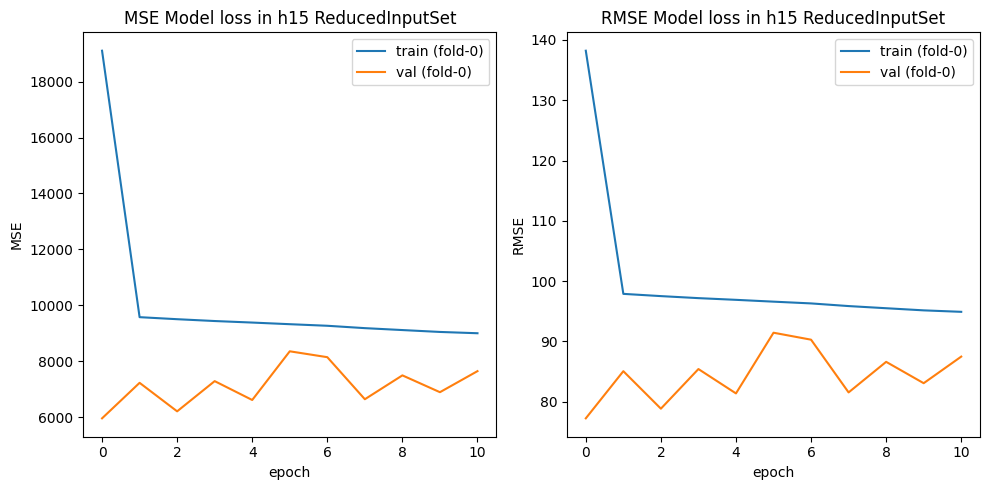


 Create ANN model for mlp_h15_fold1_ReducedInputSet

[INFO] Training model with 8 inputs

[INFO] Training model mlp_h15_fold1_ReducedInputSet:
Epoch 1/200
3145/3145 [==============================] - 17s 5ms/step - loss: 19105.8633 - mse: 19105.8633 - mae: 82.9723 - root_mean_squared_error: 129.4074 - val_loss: 6993.3965 - val_mse: 6993.3965 - val_mae: 61.9821 - val_root_mean_squared_error: 83.6265
Epoch 2/200
  24/3145 [..............................] - ETA: 13s - loss: 9396.7900 - mse: 9396.7900 - mae: 63.5577 - root_mean_squared_error: 96.9370

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3145/3145 [==============================] - 18s 6ms/step - loss: 9545.8672 - mse: 9545.8672 - mae: 62.4247 - root_mean_squared_error: 97.7030 - val_loss: 6210.3359 - val_mse: 6210.3359 - val_mae: 55.5281 - val_root_mean_squared_error: 78.8057
Epoch 3/200
3145/3145 [==============================] - 18s 6ms/step - loss: 9467.5537 - mse: 9467.5537 - mae: 61.7477 - root_mean_squared_error: 97.3014 - val_loss: 5953.4165 - val_mse: 5953.4165 - val_mae: 53.4572 - val_root_mean_squared_error: 77.1584
Epoch 4/200
3145/3145 [==============================] - 17s 5ms/step - loss: 9411.7246 - mse: 9411.7246 - mae: 61.2853 - root_mean_squared_error: 97.0140 - val_loss: 5947.5254 - val_mse: 5947.5254 - val_mae: 53.8090 - val_root_mean_squared_error: 77.1202
Epoch 5/200
3145/3145 [==============================] - 17s 5ms/step - loss: 9310.3848 - mse: 9310.3848 - mae: 60.4683 - root_mean_squared_error: 96.4903 - val_loss: 6549.4922 - val_mse: 6549.4922 - val_mae: 58.9677 - val_root_mean_squared_err

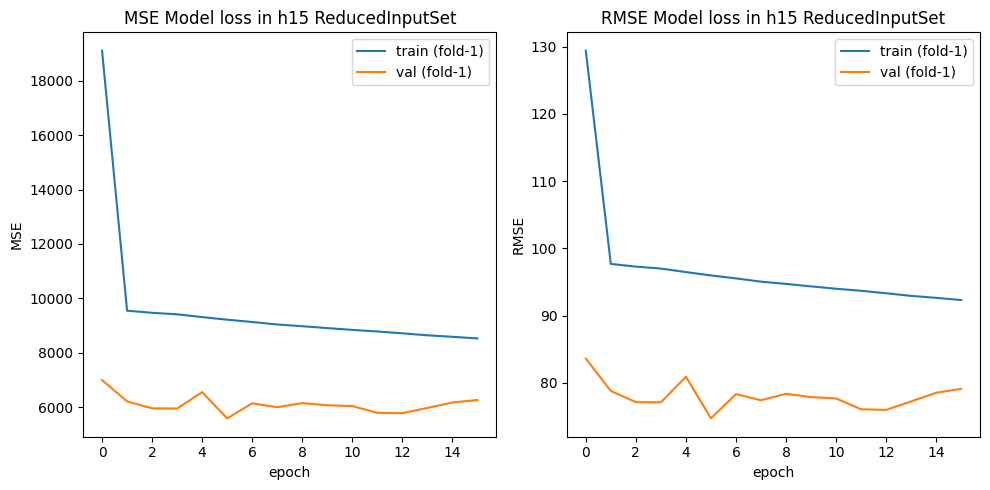


 Create ANN model for mlp_h15_fold2_ReducedInputSet

[INFO] Training model with 8 inputs

[INFO] Training model mlp_h15_fold2_ReducedInputSet:
Epoch 1/200
3152/3152 [==============================] - 18s 5ms/step - loss: 17727.3906 - mse: 17727.3906 - mae: 79.6076 - root_mean_squared_error: 124.2506 - val_loss: 8005.0684 - val_mse: 8005.0684 - val_mae: 64.0600 - val_root_mean_squared_error: 89.4710
Epoch 2/200
  29/3152 [..............................] - ETA: 11s - loss: 8579.6426 - mse: 8579.6426 - mae: 59.7758 - root_mean_squared_error: 92.6264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3152/3152 [==============================] - 17s 5ms/step - loss: 8635.4854 - mse: 8635.4854 - mae: 59.8228 - root_mean_squared_error: 92.9273 - val_loss: 8286.6709 - val_mse: 8286.6709 - val_mae: 66.1566 - val_root_mean_squared_error: 91.0312
Epoch 3/200
3152/3152 [==============================] - 17s 5ms/step - loss: 8603.5674 - mse: 8603.5674 - mae: 59.5425 - root_mean_squared_error: 92.7554 - val_loss: 7848.2720 - val_mse: 7848.2720 - val_mae: 62.9464 - val_root_mean_squared_error: 88.5905
Epoch 4/200
3152/3152 [==============================] - 18s 6ms/step - loss: 8565.8760 - mse: 8565.8760 - mae: 59.2605 - root_mean_squared_error: 92.5520 - val_loss: 8522.6631 - val_mse: 8522.6631 - val_mae: 67.8996 - val_root_mean_squared_error: 92.3183
Epoch 5/200
3152/3152 [==============================] - 17s 6ms/step - loss: 8533.6523 - mse: 8533.6523 - mae: 59.1764 - root_mean_squared_error: 92.3778 - val_loss: 8228.8936 - val_mse: 8228.8936 - val_mae: 65.5150 - val_root_mean_squared_err

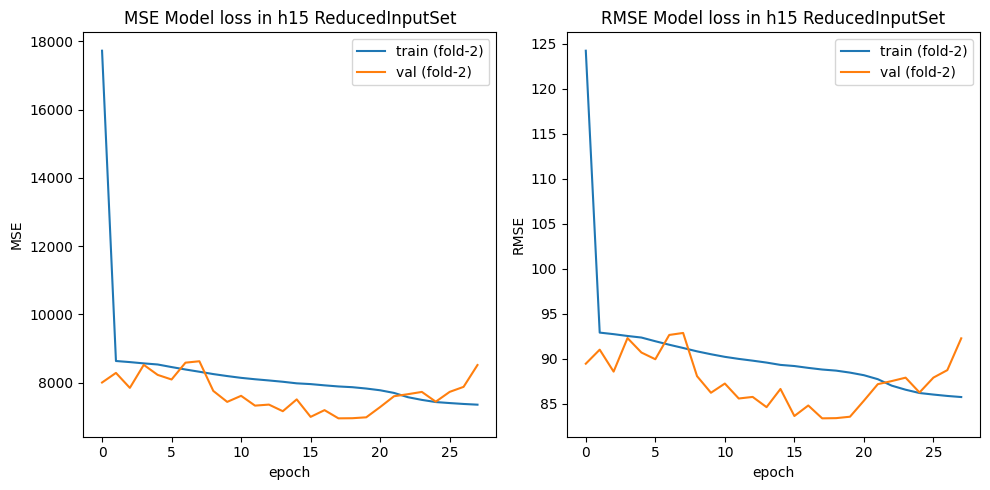

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Set 0 = complete, 1 = medium, 2 = reduced
conjuntos = [2]
foldes = [0,1,2]

if TRAINING_MODELS:
  rmset = tf.keras.metrics.RootMeanSquaredError()
  # mapet = tf.keras.metrics.MeanAbsolutePercentageError()
  early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

  # for each input set (inputs)
  for id_set in conjuntos:
    dftemp = df.copy()
    # list with the names of the models
    model_name = []
    # list to store the 3 models (one for each fold)
    models = []
    # list of training and validation histories for each fold/model
    histories = []
    # Experiment seed to allow repeatability
    seed = 2459
    # For each fold, create its respective model in models[]
    # for i_fold in range(start_fold, num_folds):
    for i_fold in foldes:
      print(f'\n Create ANN model for mlp_h{horizon}_fold{i_fold}_{setNames[id_set]}')
      model_name.append(f'mlp_h{horizon}_fold{i_fold}_{setNames[id_set]}')

      ############# Create Model #############
      models.append(Sequential())
      print(f'\n[INFO] Training model with {(X_list[id_set]).shape[1]} inputs')
      # Input Layer
      models[i_fold].add(Dense((X_train_list[id_set])[0].shape[1], activation='relu', input_dim = (X_list[id_set]).shape[1]))
      # Hidden Layers
      models[i_fold].add(Dense(30, activation='relu', kernel_initializer='normal'))
      models[i_fold].add(Dense(210, activation='relu', kernel_initializer='normal'))
      models[i_fold].add(Dense(150, activation='relu', kernel_initializer='normal'))

      # Output Layer
      models[i_fold].add(Dense(1, activation='relu', kernel_initializer='normal'))

      ############# Training Model #############
      clear_session()
      path_to_save_model = output + f'mlp_h{horizon}_fold{i_fold}_{setNames[id_set]}' + "_model.h5"
      save = ModelCheckpoint(filepath=path_to_save_model,
                              monitor="val_loss",
                              save_best_only=True)
      models[i_fold].compile(loss='mse', optimizer='adam', metrics=['mse','mae', rmset])
      print(f"\n[INFO] Training model {model_name[i_fold]}:")
      start = time.time()
      with tf.device('/device:GPU:0'):
        history = models[i_fold].fit(
            x=X_train_list[id_set][i_fold],
            y=y_train[i_fold].values,
            validation_split=0.2,
            batch_size=128, epochs=200,
            callbacks=[early_stop, save])
      histories.append(history)
      end = time.time()

      print(f"\n[INFO] Model {model_name[i_fold]} took: {((end-start)/60):.2f} minutes to reach earlyStop")

      ############# Plot Train/Validation Model #############
      fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,5), dpi=100)
      axs[0].plot(histories[i_fold].history['loss'])
      axs[0].plot(histories[i_fold].history['val_loss'])
      axs[0].set_title(f'MSE Model loss in h{horizon} {setNames[id_set]}')
      axs[0].set_ylabel('MSE')
      axs[0].set_xlabel('epoch')
      axs[0].legend([f'train (fold-{i_fold})', f'val (fold-{i_fold})'], loc='upper right')

      axs[1].plot(histories[i_fold].history['root_mean_squared_error'])
      axs[1].plot(histories[i_fold].history['val_root_mean_squared_error'])
      axs[1].set_title(f'RMSE Model loss in h{horizon} {setNames[id_set]}')
      axs[1].set_ylabel('RMSE')
      axs[1].set_xlabel('epoch')
      axs[1].legend([f'train (fold-{i_fold})', f'val (fold-{i_fold})'], loc='upper right')

      plt.tight_layout()
      fig.savefig(output + f'mlp_h{horizon}_fold{i_fold}_{setNames[id_set]}_learning_curve.jpg')
      plt.show()

# Predictions of the 3 folds for each input set and selected horizon



In [ ]:
from datetime import datetime

if MAKE_PREDICTIONS:
  # for each input set (inputs)
  for id_set in conjuntos:

    models = []
    model_name = []
    # For each fold, plot its historical training and validation accuracy
    # for i in range(start_fold, num_folds):

    print(f'\n[INFO] This MLP model uses {len(X_list[id_set].columns.values)} input features which are: {X_list[id_set].columns.values}')
    print(f'\n[INFO] Model MLP structure:')
    # print(models[0].summary())

    # create one result accuracy dataframe for each fold and all horizons
    columns = ['Model', 'fold', 'horizon', 'mae', 'mse', 'rmse','nrmse','mape', 'mase', 'fss', 'r2']
    df_accuracy = pd.DataFrame(columns=columns)

    for i_fold in foldes:
      print(f'\n######## Load model for fold {i_fold}, horizon {horizon} with {setNames[id_set]} ########')
      model_name.append(f'mlp_h{horizon}_fold{i_fold}_{setNames[id_set]}')
      path_model = output + model_name[i_fold] + "_model.h5"
      models.append(tf.keras.models.load_model(path_model))
    # plot_model(models[0], to_file=f'{output}mlp_model_structure.jpg', show_shapes=True, show_layer_names=True)

    # For each fold, plot its historical training and validation accuracy
    for i in foldes:
      print(f'\n######## Make predictions for fold {i}, horizon {horizon} with {setNames[id_set]} ########\n')
      # X_test.sort_index(inplace=True)
      predictions = models[i].predict(X_test_list[id_set][i])
      # prediction = scalerY.inverse_transform(predictions)
      # y_test.sort_index(inplace=True)
      result = pd.DataFrame({ 'folsomGhi': y_test_list[id_set][i]})
      result['predictedGhi'] = predictions
      # result.sort_index(inplace=True)

      # Save the predictions of each model/fold
      result.to_excel(output +  f'mlp_h{horizon}_fold{i}_{setNames[id_set]}_predictions.xlsx',  sheet_name='mlp_predictions') #float_format="%.5f",

      print(f'\n[INFO] ANN-MLP Accuracy results for horizon {horizon} and fold {i}')
      print(f'\n[INFO] Real GHI: min={np.min(y_test_list[id_set][i]):.2f} max={np.max(y_test_list[id_set][i]):.2f} mean={np.mean(y_test_list[id_set][i]):.2f} NaN={np.isnan(y_test_list[id_set][i]).sum():.0f}')
      print(f'[INFO] Predicted GHI: min={np.min(predictions.squeeze()):.2f} max={np.max(predictions.squeeze()):.2f} mean={np.mean(predictions.squeeze()):.2f} nan={np.isnan(predictions.squeeze()).sum():.0f}')

      mae_value = mae_err(y_test_list[id_set][i],predictions.squeeze())
      print('\nMAE = ', mae_value)
      mse_value = mse_err(y_test_list[id_set][i],predictions.squeeze())
      print('MSE = ', mse_value)
      rmse_value = rmse_err(y_test_list[id_set][i],predictions.squeeze())
      print('RMSE = ', rmse_value)
      nrmse_value = nrmse_err(y_test_list[id_set][i],predictions.squeeze())
      print(f"nRMSE: {nrmse_value}")
      mape_value = mape_err(y_test_list[id_set][i],predictions.squeeze())
      print(f"MAPE: {mape_value} %")
      mase_value = mase_err(y_test_list[id_set][i],predictions.squeeze())
      print(f"MASE: {mase_value} %")
      fss_value = fss_err(y_test_list[id_set][i],predictions.squeeze())
      print(f"SS: {fss_value} %")
      r2_value = r2_score(y_test_list[id_set][i],predictions.squeeze())
      print(f"R2: {r2_value} %")

      acc_results = []
      acc_results.append(model_name[i])
      acc_results.append(i)
      acc_results.append(horizon)
      acc_results.append(mae_value)
      acc_results.append(mse_value)
      acc_results.append(rmse_value)
      acc_results.append(nrmse_value)
      acc_results.append(mape_value)
      acc_results.append(mase_value)
      acc_results.append(fss_value)
      acc_results.append(r2_value)
      df_accuracy.loc[len(df_accuracy.index)] = acc_results

      now = datetime.now()
      dt_string = now.strftime("%d-%m-%Y_%Hh%Mm%Ss")
      df_accuracy.to_excel(output + f'mlp_h{horizon}_fold{i}_{setNames[id_set]}_input2_accuracy_{dt_string}.xlsx')



[INFO] This MLP model uses 8 input features which are: ['year' 'month' 'day' 'hour' 'minute' 'cloudsMovement' 'cloudsSunAround'
 'fitLuminanceCSI']

[INFO] Model MLP structure:

######## Load model for fold 0, horizon 15 with ReducedInputSet ########

######## Load model for fold 1, horizon 15 with ReducedInputSet ########

######## Load model for fold 2, horizon 15 with ReducedInputSet ########

######## Make predictions for fold 0, horizon 15 with ReducedInputSet ########

7583/7583 [==============================] - 14s 2ms/step

[INFO] ANN-MLP Accuracy results for horizon 15 and fold 0

[INFO] Real GHI: min=0.00 max=1366.00 mean=411.19 NaN=0
[INFO] Predicted GHI: min=0.07 max=952.67 mean=374.32 nan=0

MAE =  83.75677990823542
MSE =  12668.584389603466
RMSE =  112.55480615950376
nRMSE: 0.08239736907723555
MAPE: 27.01356100046017 %
MASE: 7.385702715050002 %
SS: -196.65721753756412 %
R2: 0.856293560723931 %

######## Make predictions for fold 1, horizon 15 with ReducedInputSet ######

# End